In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


normal_dataset = pd.read_excel('../models/normal.xlsx')
normal_dataset.head()

anomaly_dataset = pd.read_excel('../models/anomaly.xlsx')
anomaly_dataset.head()

,Time,Intensity,Current
0,2022-02-04 10:57:33.695,0.000004,7.310214e-08
1,2022-02-04 10:57:33.816,0.000007,1.146507e-07
2,2022-02-04 10:57:33.936,0.000008,1.010314e-07
3,2022-02-04 10:57:34.056,0.000007,1.019369e-07
4,2022-02-04 10:57:34.177,0.000006,8.269153e-08


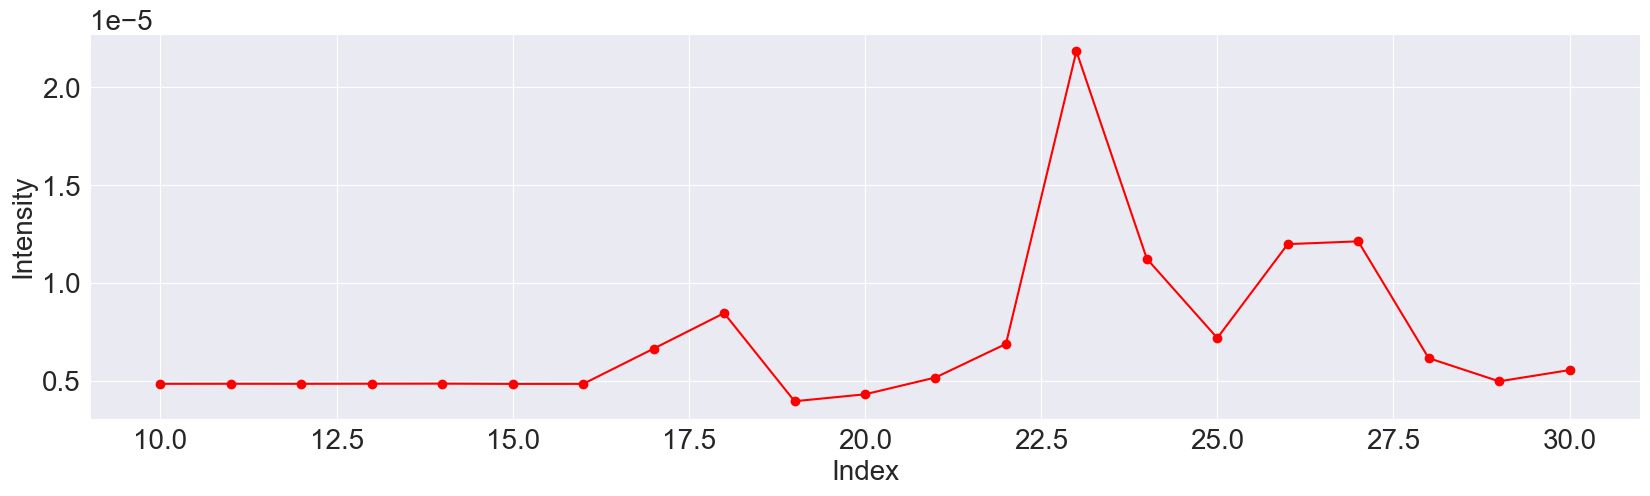

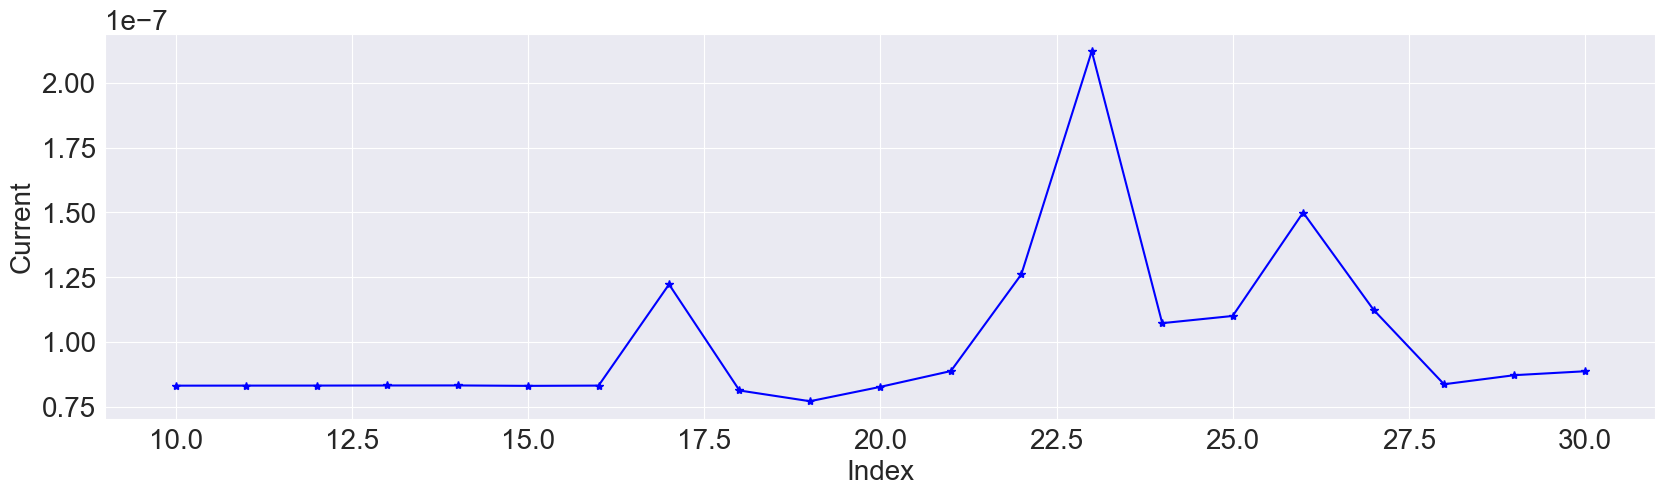

In [40]:
plt.rc('font', size=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

plt.figure(figsize=(20, 5))
plt.xlabel('Index')
plt.ylabel('Intensity')
plt.plot(normal_dataset['Intensity'][10:31], marker='o', color='red')
plt.show()

plt.figure(figsize=(20, 5))
plt.xlabel('Index')
plt.ylabel('Current')
plt.plot(normal_dataset['Current'][10:31], marker='*', color='blue')
plt.show()

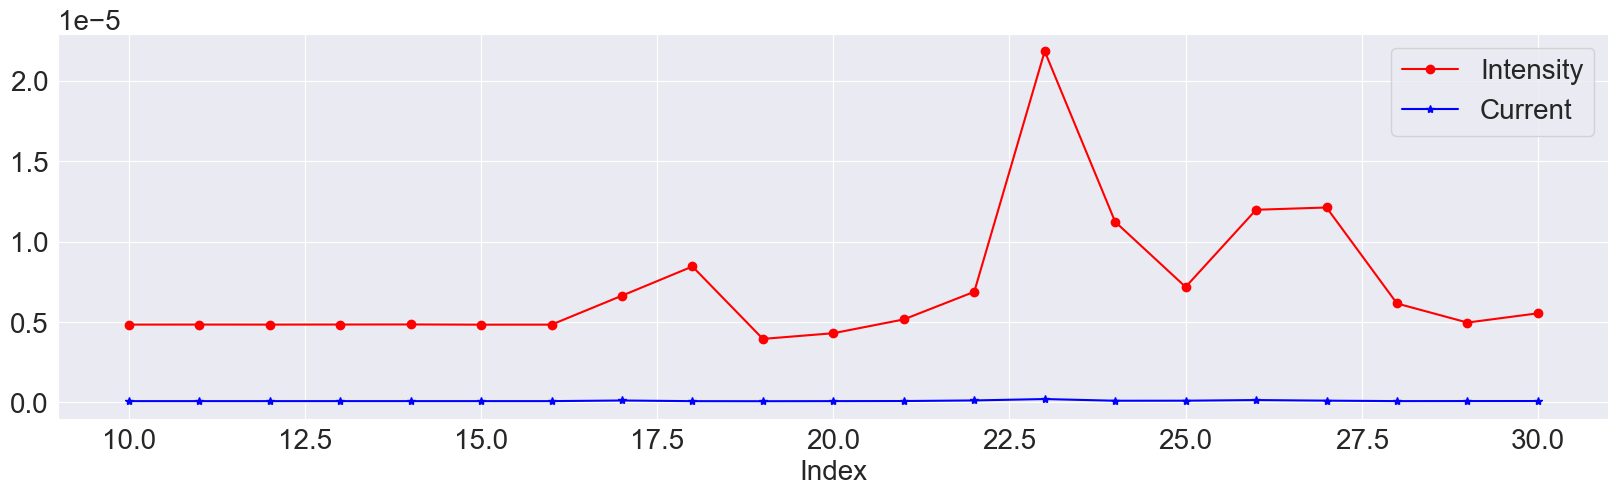

In [41]:
plt.figure(figsize=(20, 5))
plt.xlabel('Index')
plt.plot(normal_dataset['Intensity'][10:31], marker='o', color='red', label='Intensity')
plt.plot(normal_dataset['Current'][10:31], marker='*', color='blue', label='Current')
plt.legend()
plt.show()

normal_dataset.info()
normal_dataset.describe()


anomaly_dataset.info()
anomaly_dataset.describe()


In [42]:
normal_dataset.corr()

,Intensity,Current
Intensity,1.000000,0.835255
Current,0.835255,1.000000


In [43]:
anomaly_dataset.corr()

,Intensity,Current
Intensity,1.000000,0.717665
Current,0.717665,1.000000


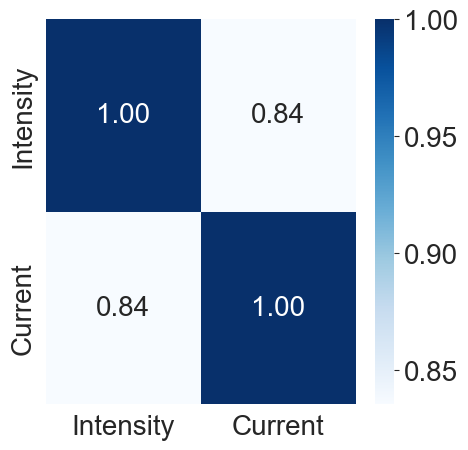

In [44]:
plt.figure(figsize=(5,5))
sns.heatmap(data=normal_dataset.corr(), annot=True, fmt='.2f', cmap='Blues')
plt.show()

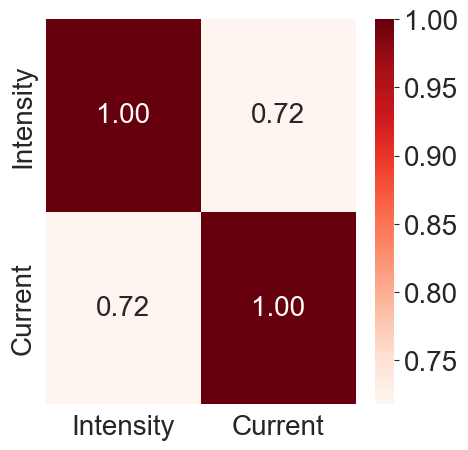

In [45]:
plt.figure(figsize=(5,5))
sns.heatmap(data=anomaly_dataset.corr(), annot=True, fmt='.2f', cmap='Reds')
plt.show()

In [46]:
train_dataset = normal_dataset['Intensity'][:80480].values
test_dataset = pd.concat([normal_dataset['Intensity'][80480:], anomaly_dataset['Intensity']],
ignore_index=True).values
print('학습데이터 수:', len(train_dataset))
print('평가데이터 수:', len(test_dataset))

학습데이터 수: 80480
평가데이터 수: 23600


In [47]:
type(train_dataset)
type(test_dataset)
train_dataset.shape
test_dataset.shape


(23600,)

In [48]:
scaler = StandardScaler()
train_dataset = scaler.fit_transform(train_dataset.reshape(-1, 1))
test_dataset = scaler.transform(test_dataset.reshape(-1, 1))

In [49]:
train_dataset.shape
test_dataset.shape


(23600, 1)

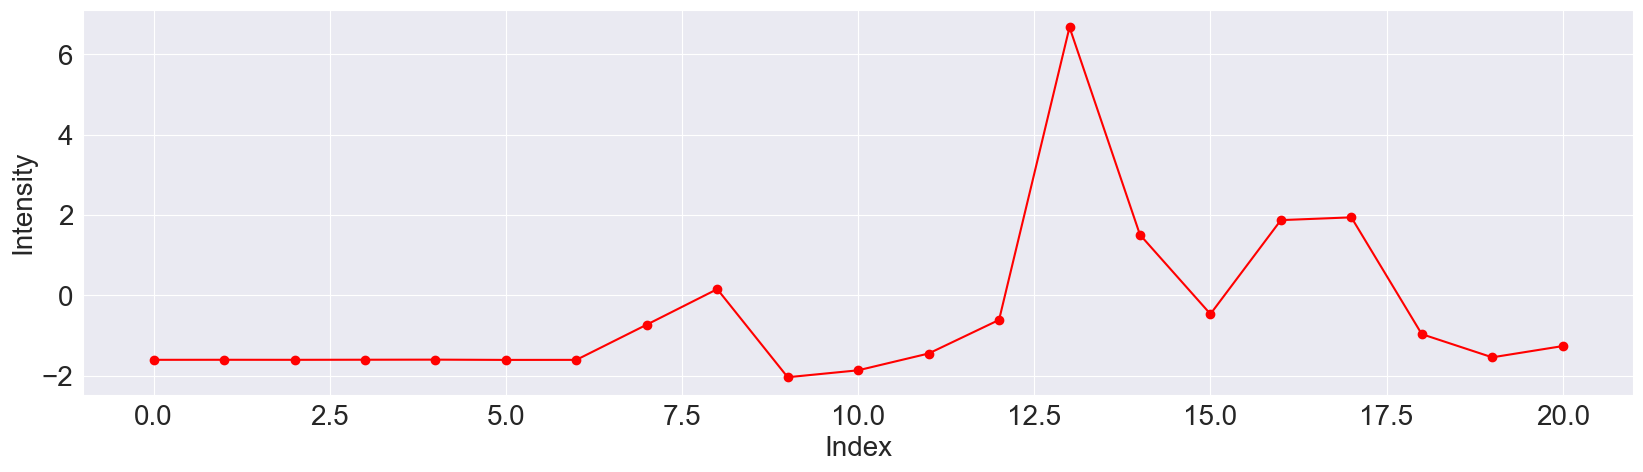

In [50]:
plt.figure(figsize=(20, 5))
plt.xlabel('Index')
plt.ylabel('Intensity')
plt.plot(train_dataset[10:31], marker='o', color='red')
plt.show()

In [51]:
time_step = 40
train_dataset = train_dataset.reshape(-1, time_step, 1)
test_dataset = test_dataset.reshape(-1, time_step, 1)
print('학습데이터 Shape:', train_dataset.shape)
print('평가데이터 Shape:', test_dataset.shape)

학습데이터 Shape: (2012, 40, 1)
평가데이터 Shape: (590, 40, 1)


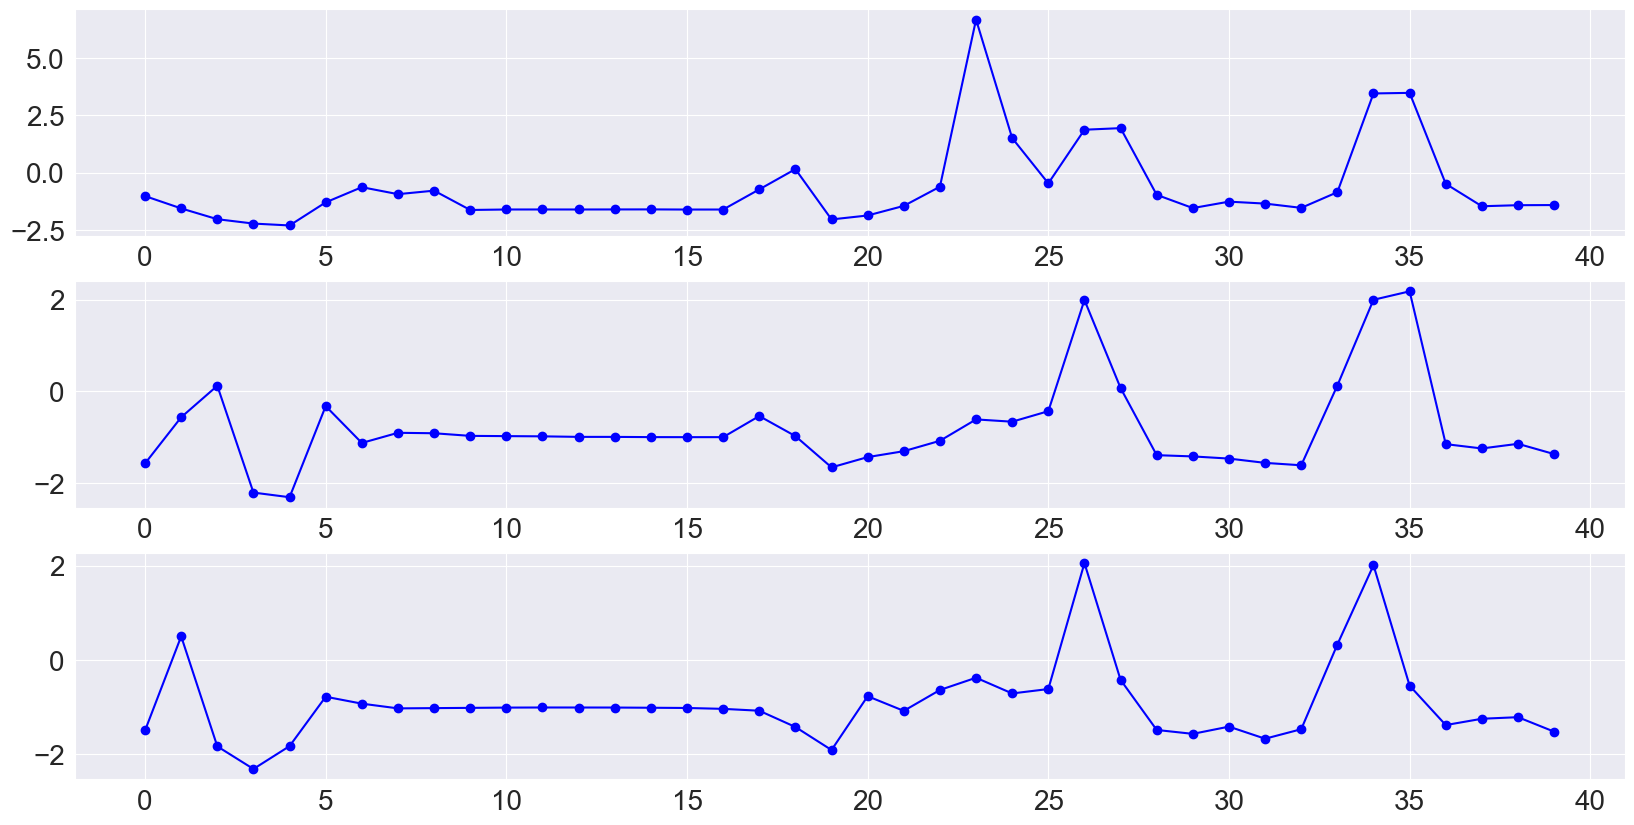

In [52]:
plt.figure(figsize=(20,10))
plt.subplot(3, 1, 1)
plt.plot(train_dataset[0], marker='o', color='blue')
plt.subplot(3, 1, 2)
plt.plot(train_dataset[1], marker='o', color='blue')
plt.subplot(3, 1, 3)
plt.plot(train_dataset[2], marker='o', color='blue')
plt.show()

In [53]:
model = Sequential()
model.add(LSTM(units=250, activation='tanh', input_shape=(time_step, 1)))
model.add(RepeatVector(n=time_step))
model.add(LSTM(units=250, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(units=1)))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 250)               252000    
                                                                 
 repeat_vector (RepeatVecto  (None, 40, 250)           0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 40, 250)           501000    
                                                                 
 time_distributed (TimeDist  (None, 40, 1)             251       
 ributed)                                                        
                                                                 
Total params: 753251 (2.87 MB)
Trainable params: 753251 (2.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
model.compile(loss='mae', optimizer='adam')
history = model.fit(x=train_dataset, y=train_dataset,
epochs=200, validation_split=0.2, callbacks=[EarlyStopping(patience=10)])

Epoch 1/200
51/51 [==============================] - 5s 56ms/step - loss: 0.6132 - val_loss: 0.6044
Epoch 2/200
51/51 [==============================] - 3s 51ms/step - loss: 0.5881 - val_loss: 0.5933
Epoch 3/200
51/51 [==============================] - 2s 47ms/step - loss: 0.5823 - val_loss: 0.5839
Epoch 4/200
51/51 [==============================] - 2s 49ms/step - loss: 0.5751 - val_loss: 0.5710
Epoch 5/200
51/51 [==============================] - 2s 48ms/step - loss: 0.5648 - val_loss: 0.5709
Epoch 6/200
51/51 [==============================] - 3s 51ms/step - loss: 0.5545 - val_loss: 0.5538
Epoch 7/200
51/51 [==============================] - 3s 54ms/step - loss: 0.5425 - val_loss: 0.5549
Epoch 8/200
51/51 [==============================] - 3s 52ms/step - loss: 0.5411 - val_loss: 0.5545
Epoch 9/200
51/51 [==============================] - 2s 49ms/step - loss: 0.5375 - val_loss: 0.5433
Epoch 10/200
51/51 [==============================] - 3s 52ms/step - loss: 0.5290 - val_loss: 0.5418

In [55]:
history.history['loss']

[0.6132394671440125,
 0.5881474614143372,
 0.5822532176971436,
 0.5750733613967896,
 0.5648273229598999,
 0.5545210242271423,
 0.5425417423248291,
 0.5411350727081299,
 0.537481427192688,
 0.5289660692214966,
 0.5250400304794312,
 0.5193830728530884,
 0.5109992027282715,
 0.4978353977203369,
 0.5011802315711975,
 0.4776579439640045,
 0.45983654260635376,
 0.4652664065361023,
 0.4309726059436798,
 0.4241671860218048,
 0.39634719491004944,
 0.3895843029022217,
 0.3637467622756958,
 0.358890175819397,
 0.34266147017478943,
 0.3317599594593048,
 0.31867995858192444,
 0.30427318811416626,
 0.31747564673423767,
 0.305172324180603,
 0.29555466771125793,
 0.2848082184791565,
 0.2963491380214691,
 0.2853536605834961,
 0.27124953269958496,
 0.262361079454422,
 0.26568490266799927,
 0.25180432200431824,
 0.25650855898857117,
 0.2734605073928833,
 0.2473321110010147,
 0.2451869696378708,
 0.2434692233800888,
 0.2631711959838867,
 0.2509743869304657,
 0.24108870327472687,
 0.2541845738887787,
 0.23

In [56]:
history.history['val_loss']

[0.6044025421142578,
 0.5932634472846985,
 0.5838865637779236,
 0.5710282325744629,
 0.5708936452865601,
 0.5537970662117004,
 0.5548881888389587,
 0.5545055866241455,
 0.5433424115180969,
 0.5417723655700684,
 0.5312667489051819,
 0.532881498336792,
 0.5078639388084412,
 0.508322536945343,
 0.5099749565124512,
 0.4826112687587738,
 0.47743406891822815,
 0.46762481331825256,
 0.49698278307914734,
 0.40196651220321655,
 0.44617682695388794,
 0.38772326707839966,
 0.3538212478160858,
 0.33899691700935364,
 0.33649393916130066,
 0.32587680220603943,
 0.32651570439338684,
 0.3261447250843048,
 0.30374863743782043,
 0.3062509298324585,
 0.2931039035320282,
 0.2988928258419037,
 0.3228972554206848,
 0.2864234149456024,
 0.278406023979187,
 0.29428067803382874,
 0.2678035497665405,
 0.27846819162368774,
 0.2746373116970062,
 0.27879443764686584,
 0.257470965385437,
 0.25752007961273193,
 0.31553366780281067,
 0.2776442766189575,
 0.24582819640636444,
 0.26619353890419006,
 0.24568210542201996

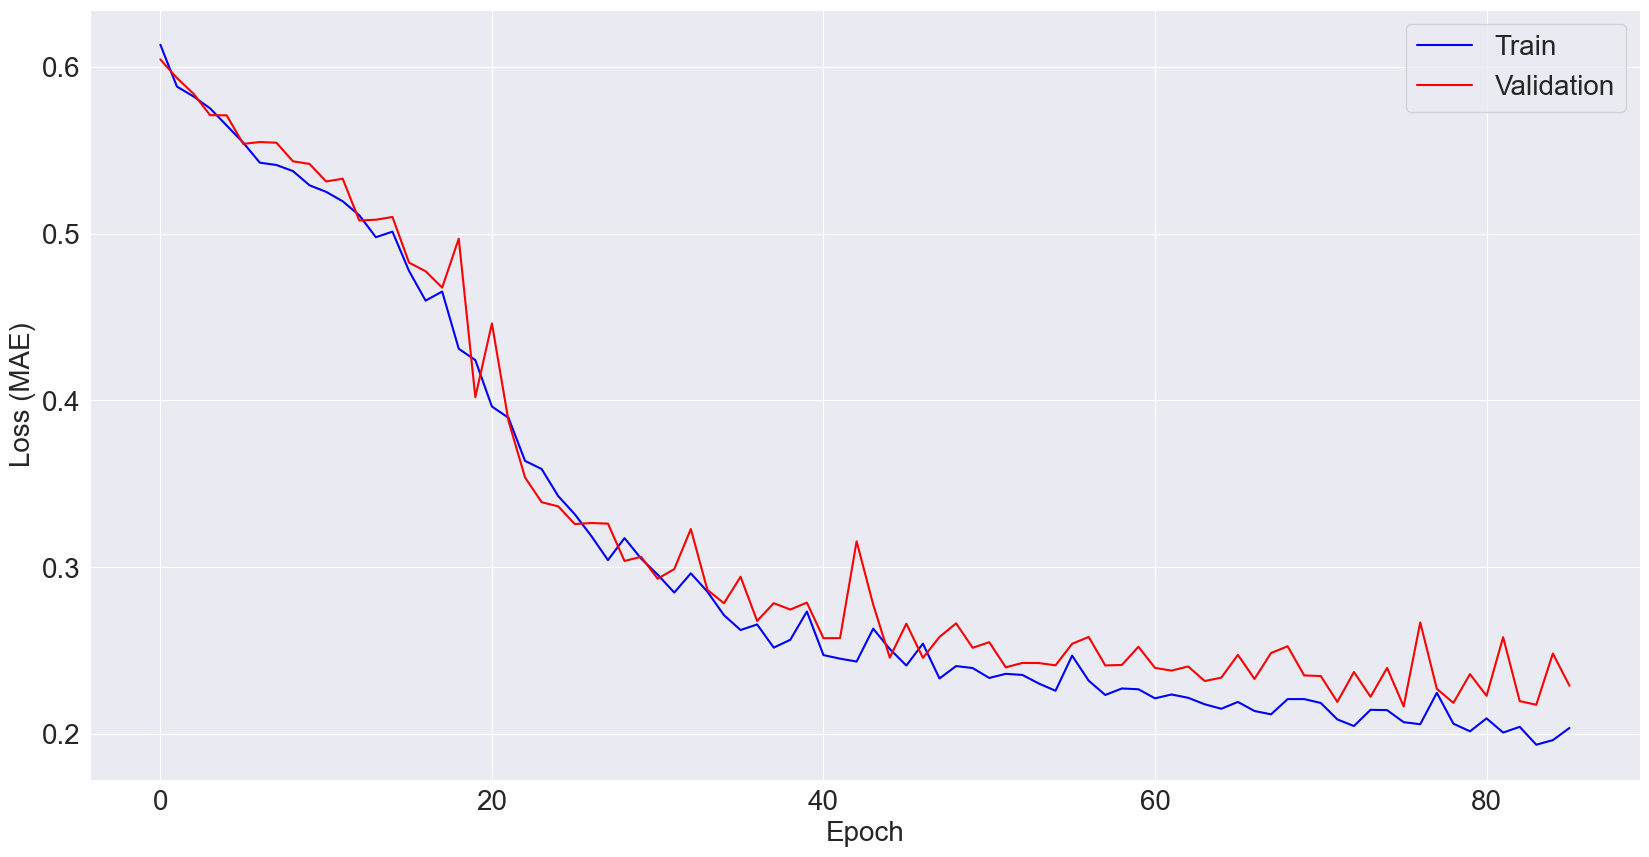

In [57]:
plt.figure(figsize=(20, 10))
plt.plot(history.history['loss'], color='blue', label='Train')
plt.plot(history.history['val_loss'], color='red', label='Validation')
plt.ylabel('Loss (MAE)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [58]:
train_yhat = model.predict(train_dataset)
train_yhat.shape

63/63 [==============================] - 2s 23ms/step


(2012, 40, 1)

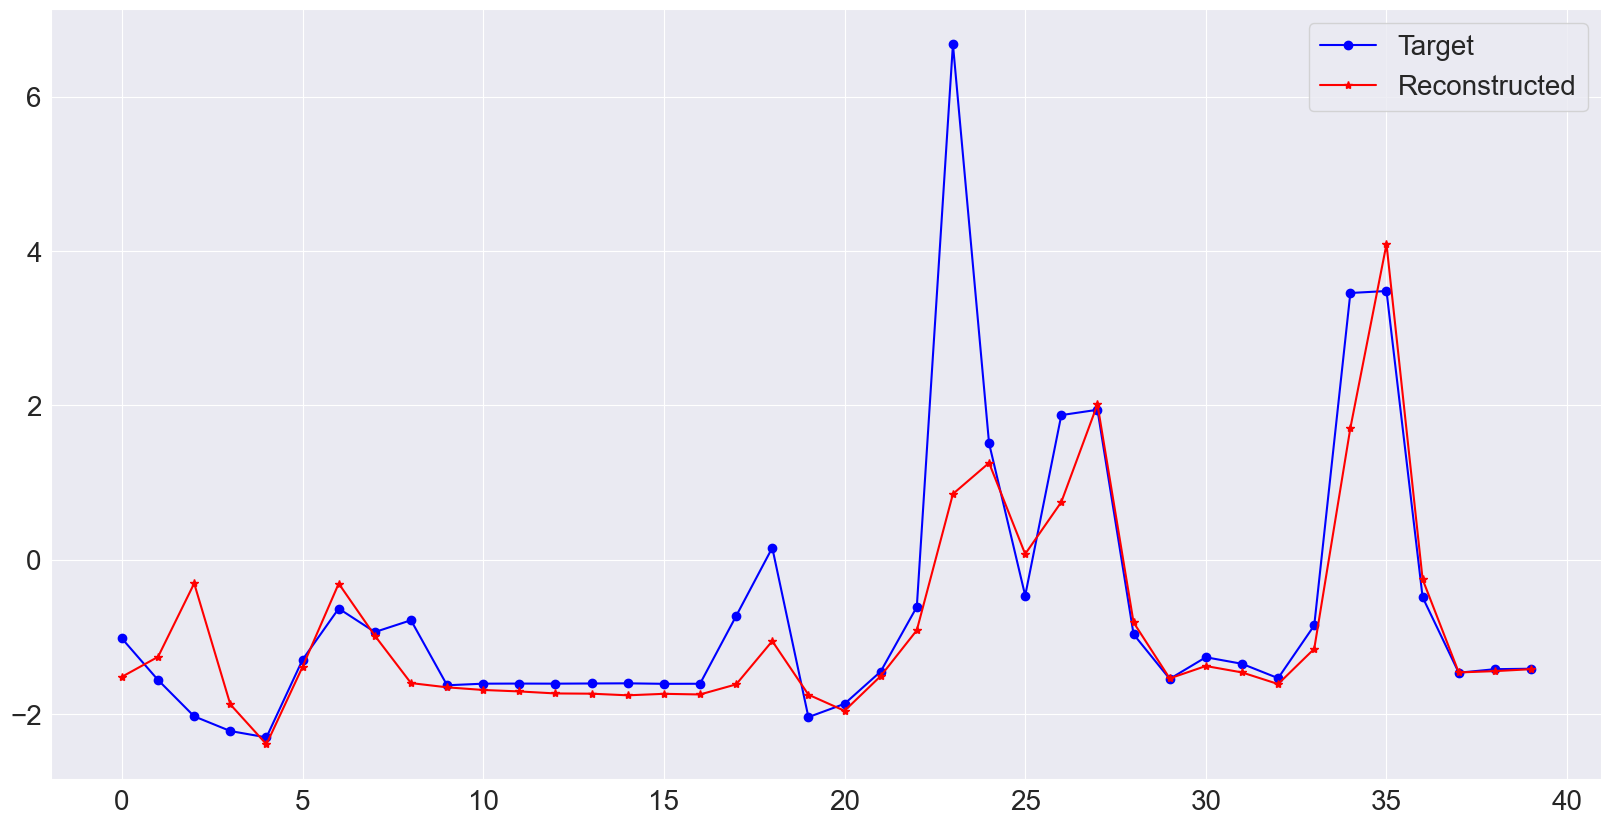

In [59]:
plt.figure(figsize=(20, 10))
plt.plot(train_dataset[0], marker='o', color='blue', label='Target')
plt.plot(train_yhat[0], marker='*', color='red', label='Reconstructed')
plt.legend()
plt.show()

In [60]:
train_mae = np.mean(np.abs(train_yhat - train_dataset), axis=1)
train_mae

array([[0.47927578],
       [0.17544104],
       [0.19938832],
       ...,
       [0.13315696],
       [0.16573939],
       [0.27931956]])

In [61]:
print('복원오차(MAE) - 최솟값:', train_mae.min())
print('복원오차(MAE) - 최댓값:', train_mae.max())

복원오차(MAE) - 최솟값: 0.09664093093168236
복원오차(MAE) - 최댓값: 0.8504290562010827


In [62]:
best_mae = np.where(train_mae == train_mae.min())[0][0]
worst_mae = np.where(train_mae == train_mae.max())[0][0]
print('복원오차(MAE) - 최솟값 인덱스:', best_mae)
print('복원오차(MAE) - 최댓값 인덱스:', worst_mae)

복원오차(MAE) - 최솟값 인덱스: 326
복원오차(MAE) - 최댓값 인덱스: 1961


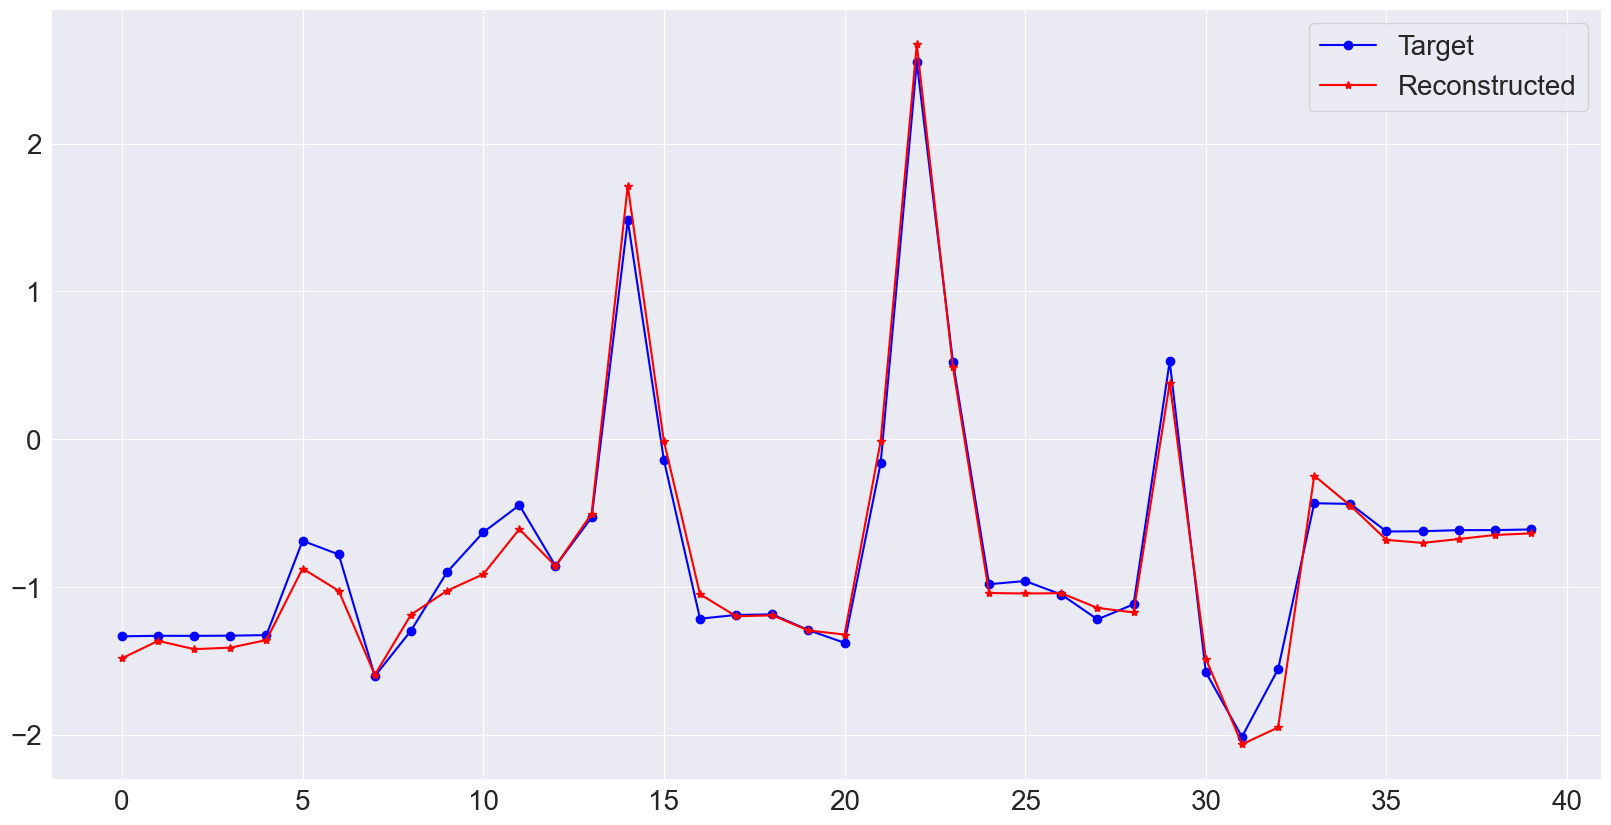

In [63]:
plt.figure(figsize=(20, 10))
plt.plot(train_dataset[best_mae], marker='o', color='blue', label='Target')
plt.plot(train_yhat[best_mae], marker='*', color='red', label='Reconstructed')
plt.legend()
plt.show()

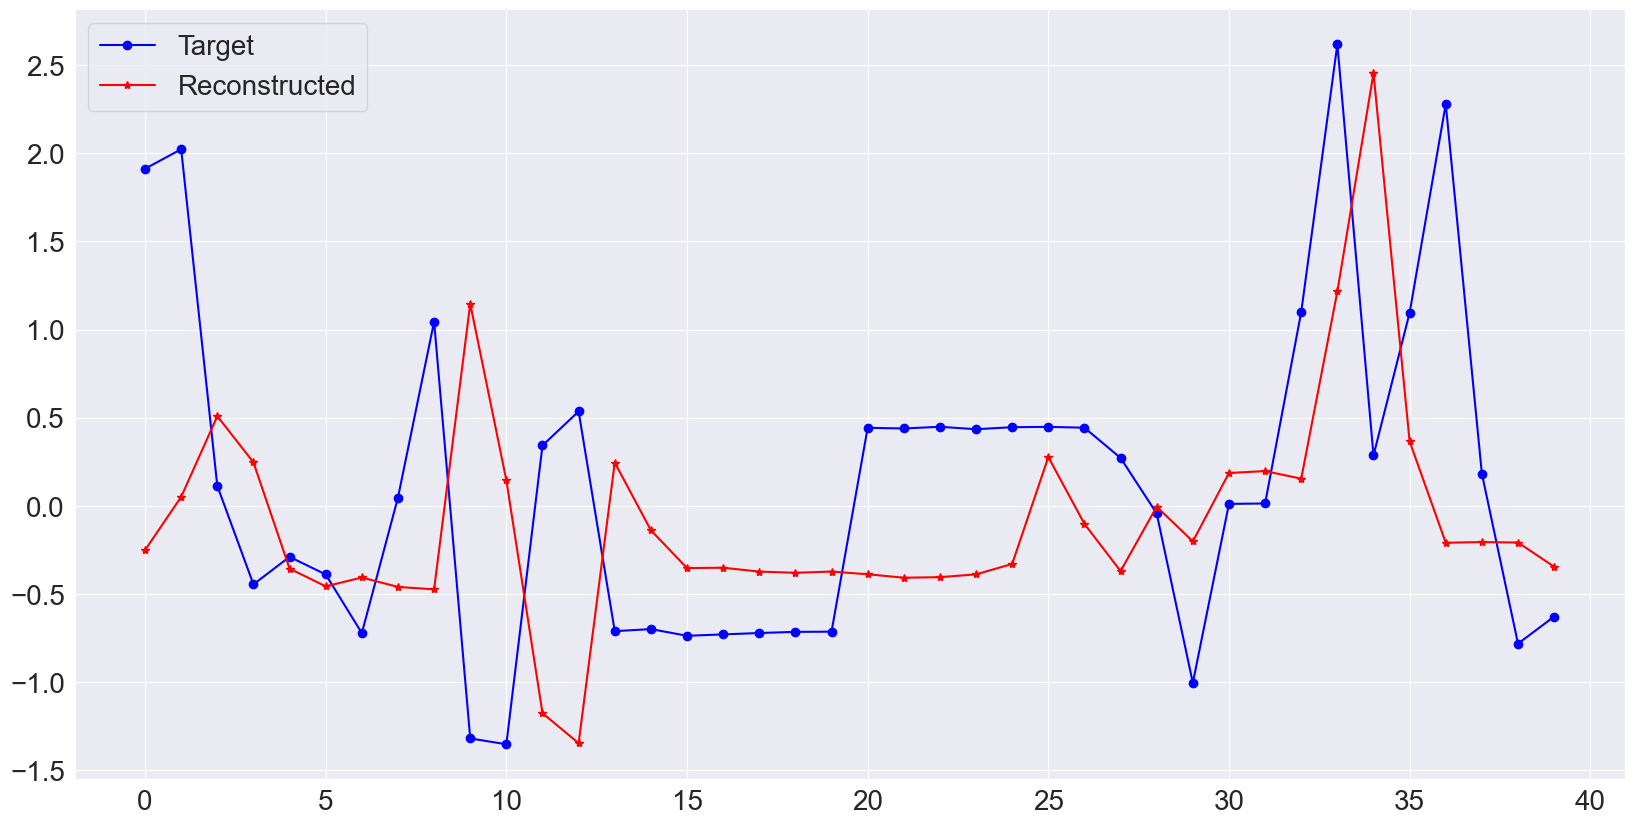

In [64]:
plt.figure(figsize=(20, 10))
plt.plot(train_dataset[worst_mae], marker='o', color='blue', label='Target')
plt.plot(train_yhat[worst_mae], marker='*', color='red', label='Reconstructed')
plt.legend()
plt.show()

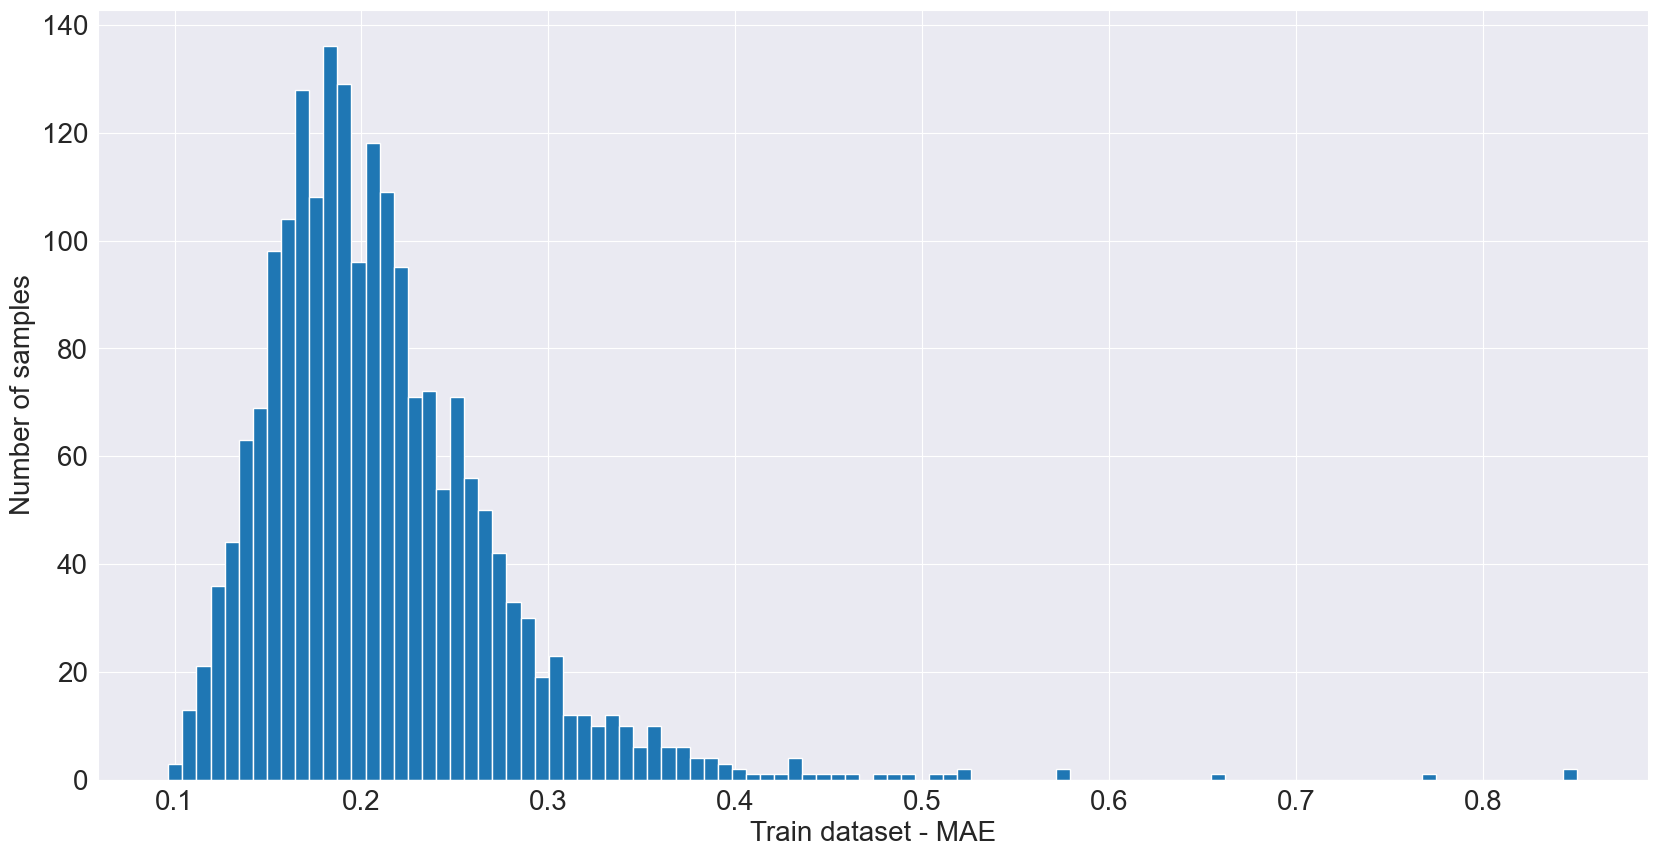

In [65]:
plt.figure(figsize=(20, 10))
plt.hist(x=train_mae, bins=100)
plt.xlabel('Train dataset - MAE')
plt.ylabel('Number of samples')
plt.show()

In [66]:
threshold = np.mean(train_mae) + 3 * np.std(train_mae)
print('임계치 :', threshold)

임계치 : 0.40596889835246663


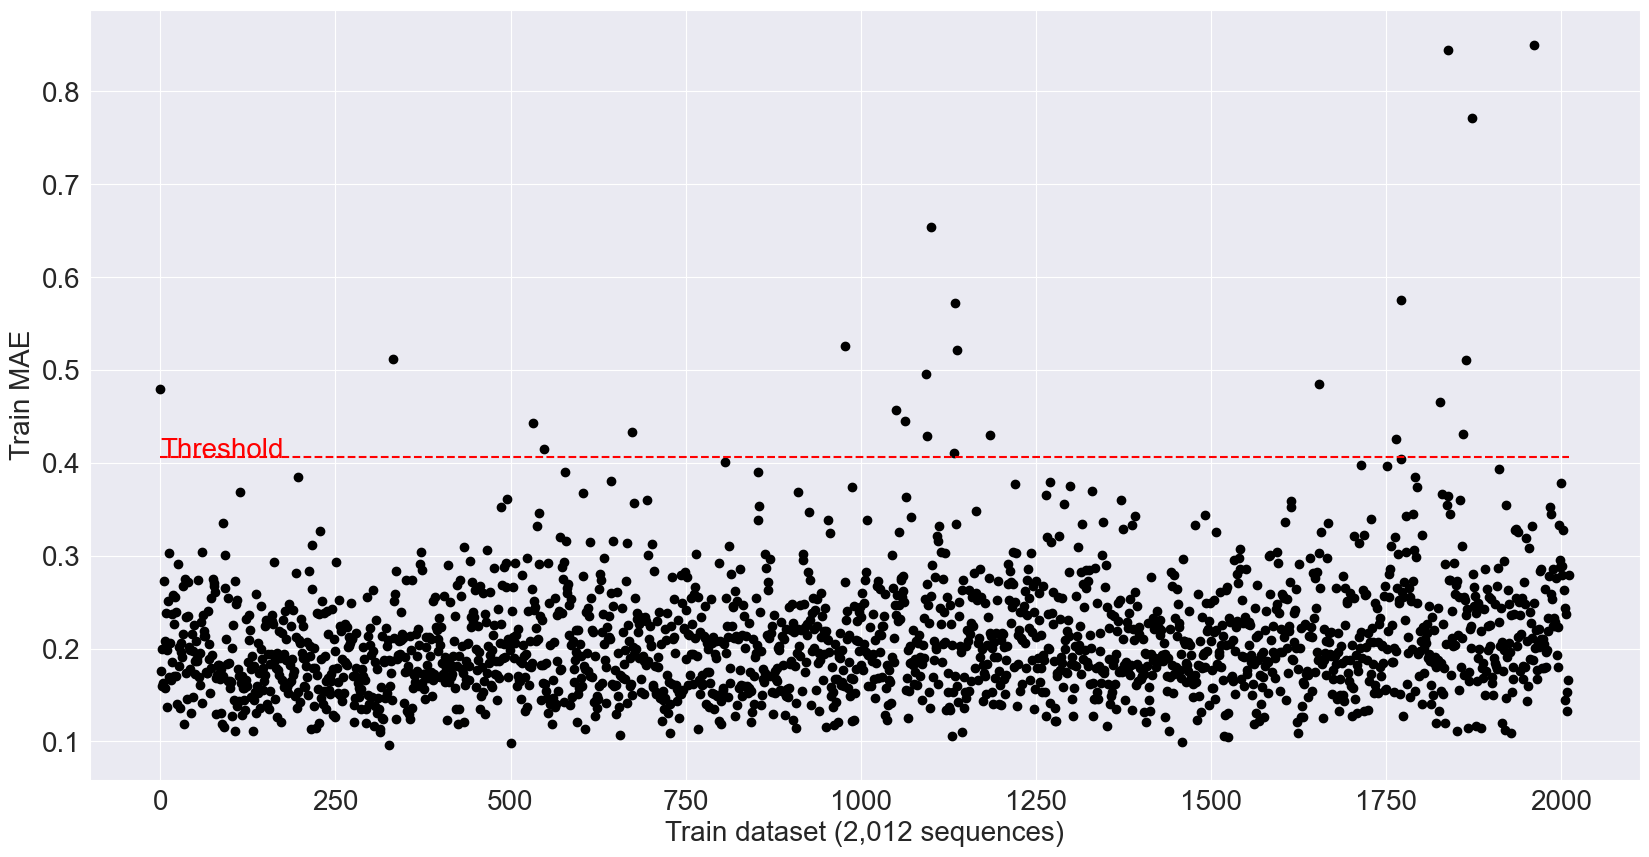

In [67]:
plt.figure(figsize=(20, 10))
plt.text(x=0, y=threshold, s='Threshold', fontsize=20, color='red')
plt.hlines(y=threshold, xmin=0, xmax=len(train_mae), color='red', linestyle='--')
plt.xlabel('Train dataset (2,012 sequences)')
plt.ylabel('Train MAE')
plt.scatter(x=np.arange(0, 2012), y=train_mae, color='black')
plt.show()

19/19 [==============================] - 0s 22ms/step


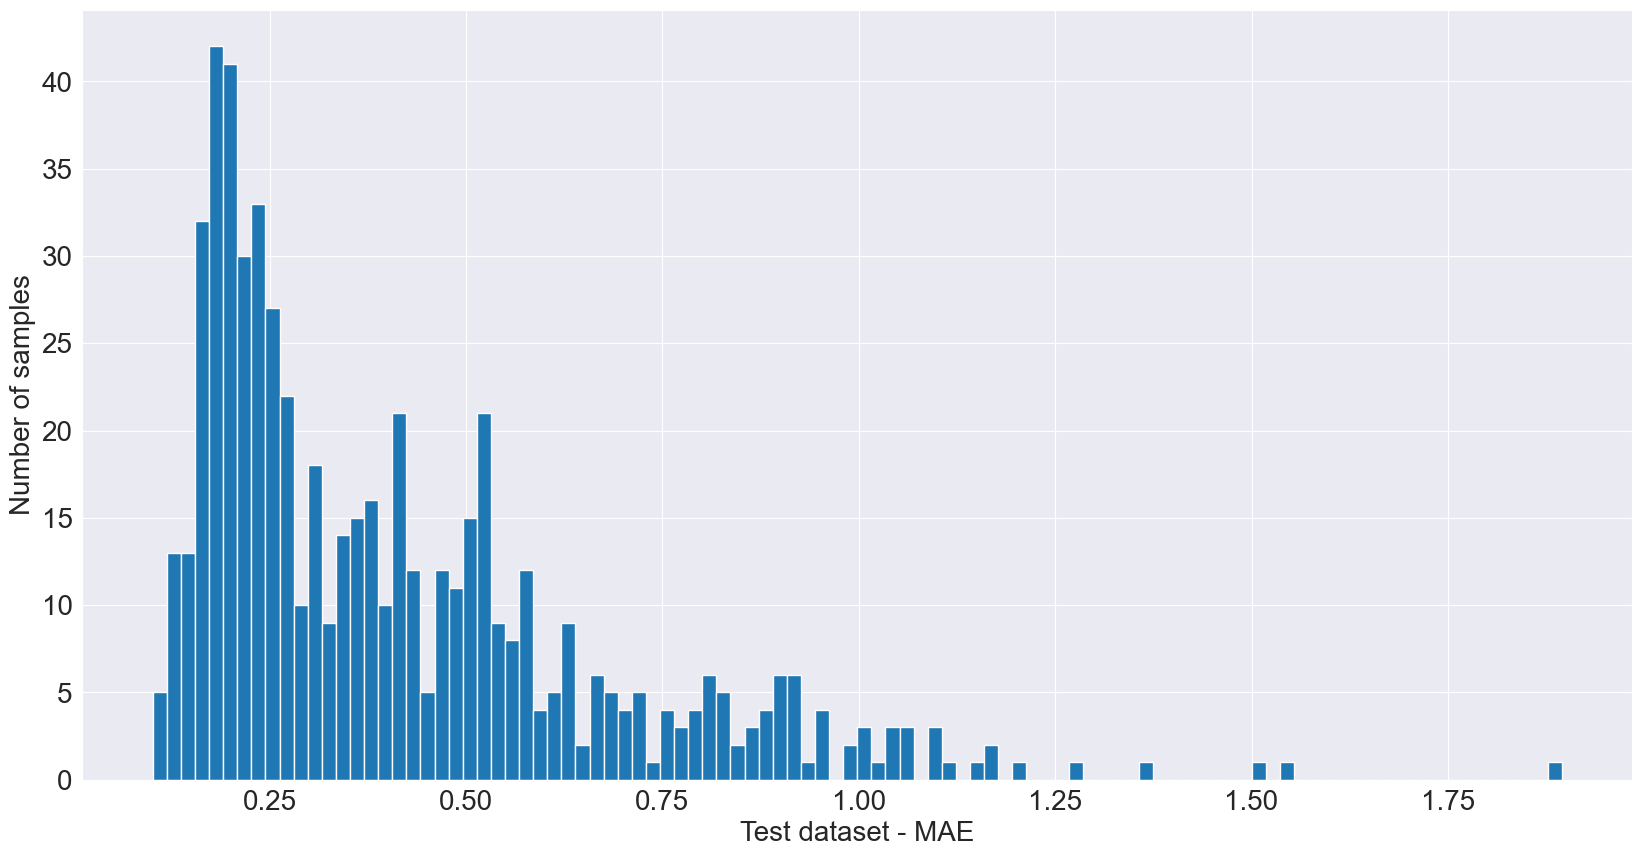

In [68]:
test_yhat = model.predict(test_dataset)
test_mae = np.mean(np.abs(test_yhat - test_dataset), axis=1)
plt.figure(figsize=(20, 10))
plt.hist(x=test_mae, bins=100)
plt.xlabel('Test dataset - MAE')
plt.ylabel('Number of samples')
plt.show()

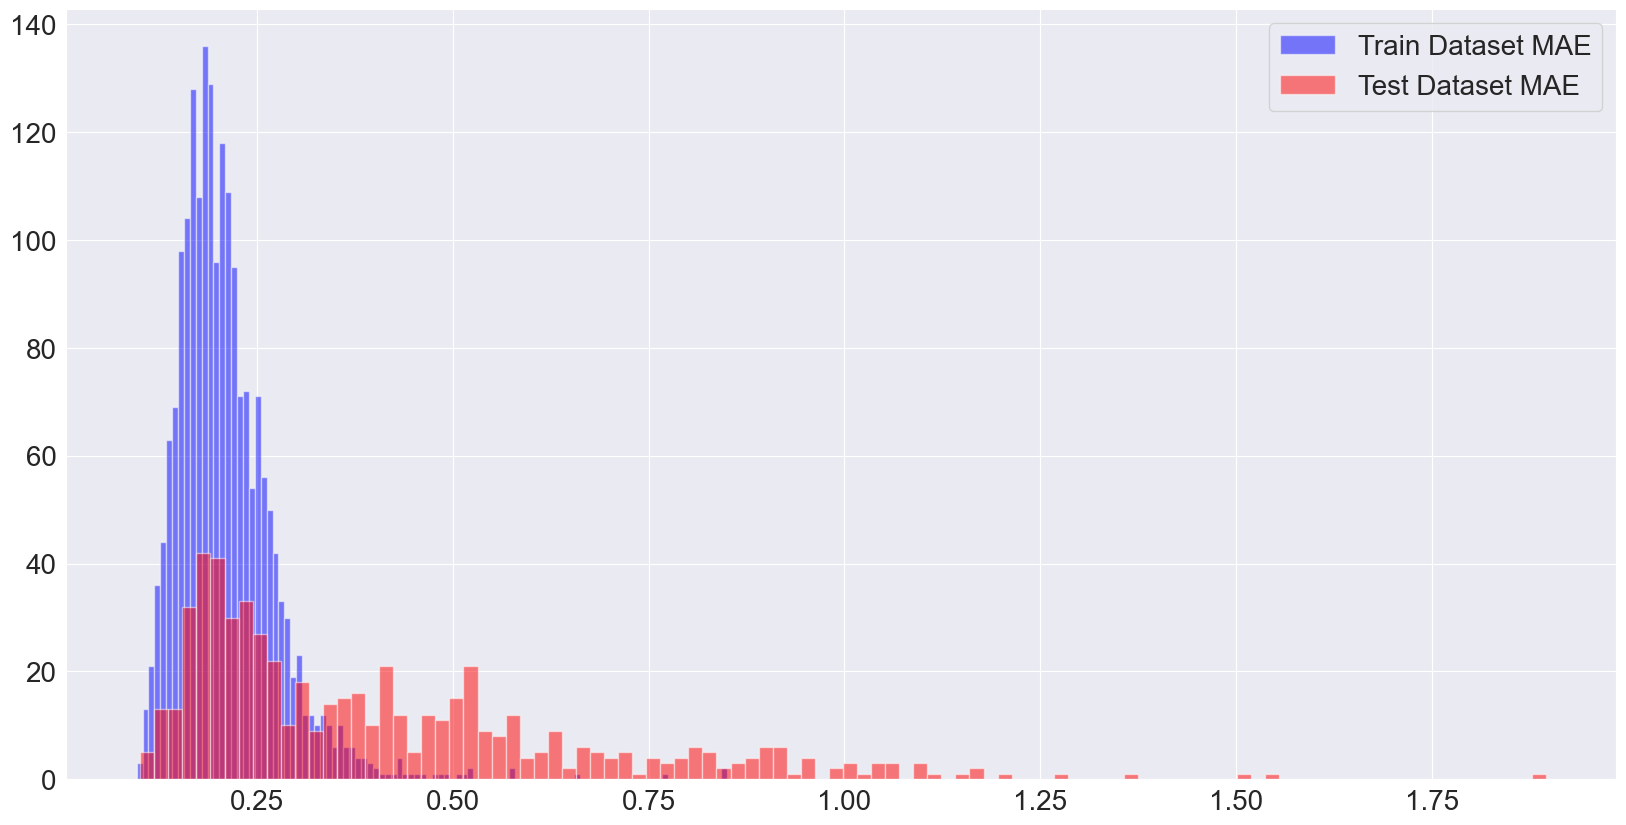

In [69]:
plt.figure(figsize=(20, 10))
plt.hist(x=train_mae, bins=100, color='blue', alpha=0.5, label='Train Dataset MAE')
plt.hist(x=test_mae, bins=100, color='red', alpha=0.5, label='Test Dataset MAE')
plt.legend()
plt.show()

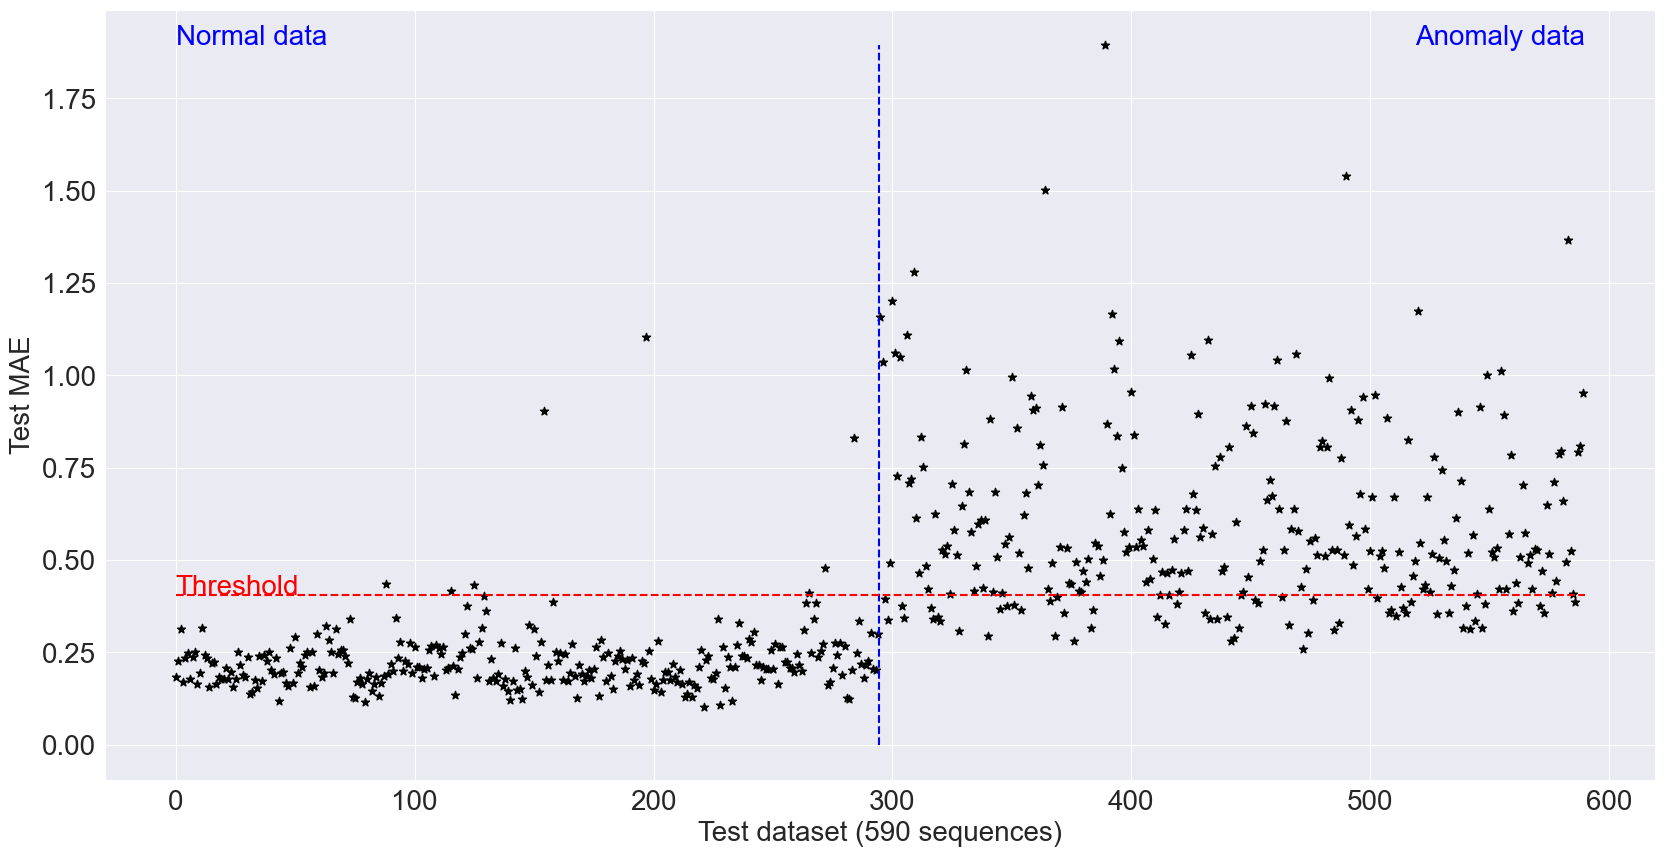

In [70]:
plt.figure(figsize=(20, 10))
plt.text(x=0, y=max(test_mae), s='Normal data', horizontalalignment='left', color='blue')
plt.text(x=len(test_mae), y=max(test_mae), s='Anomaly data', horizontalalignment='right', color='blue')
plt.vlines(x=294.5, ymin=0, ymax=max(test_mae), color='blue', linestyle='--')
plt.text(x=0, y=threshold, s='Threshold', fontsize=20, color='red')
plt.hlines(y=threshold, xmin=0, xmax=len(test_mae), color='red', linestyle='--')
plt.xlabel('Test dataset (590 sequences)')
plt.ylabel('Test MAE')
plt.scatter(x=np.arange(0, 590), y=test_mae, color='black', marker='*')
plt.show()

In [71]:
result = pd.DataFrame(data=test_mae, columns=['MAE'])
result['Target'] = -1
result['Prediction'] = -1
result

,MAE,Target,Prediction
0,0.184259,-1,-1
1,0.225064,-1,-1
2,0.314298,-1,-1
3,0.169369,-1,-1
4,0.233804,-1,-1
...,...,...,...
585,0.407469,-1,-1
586,0.385435,-1,-1
587,0.791345,-1,-1
588,0.809556,-1,-1


In [72]:
Normal = 0
Anomaly = 1
result.loc[:295, 'Target'] = Normal
result.loc[295:, 'Target'] = Anomaly
result

,MAE,Target,Prediction
0,0.184259,0,-1
1,0.225064,0,-1
2,0.314298,0,-1
3,0.169369,0,-1
4,0.233804,0,-1
...,...,...,...
585,0.407469,1,-1
586,0.385435,1,-1
587,0.791345,1,-1
588,0.809556,1,-1


In [73]:
result.loc[result['MAE'] <= threshold, 'Prediction'] = Normal
result.loc[result['MAE'] > threshold, 'Prediction'] = Anomaly
result

,MAE,Target,Prediction
0,0.184259,0,0
1,0.225064,0,0
2,0.314298,0,0
3,0.169369,0,0
4,0.233804,0,0
...,...,...,...
585,0.407469,1,1
586,0.385435,1,0
587,0.791345,1,1
588,0.809556,1,1


In [74]:
cm = confusion_matrix(result['Target'], result['Prediction'])
print('혼동행렬(Confusion Matrix) \n', cm)

혼동행렬(Confusion Matrix) 
 [[287   8]
 [ 63 232]]


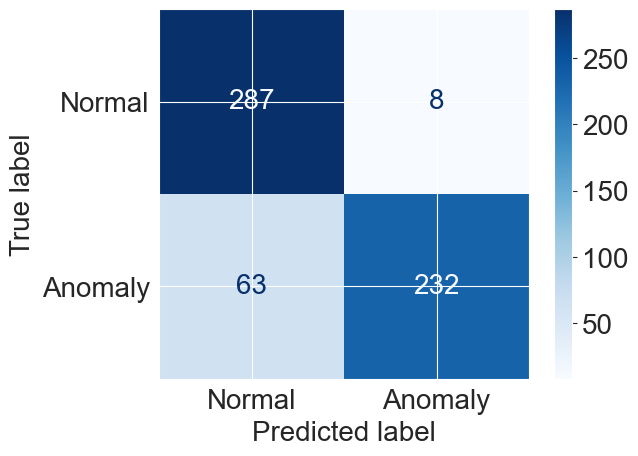

In [75]:
display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Normal', 'Anomaly'])
display.plot(cmap = plt.cm.Blues)
plt.show()

In [76]:
print(classification_report(result['Target'], result['Prediction'], target_names=['Normal', 'Anomaly']))

              precision    recall  f1-score   support

      Normal       0.82      0.97      0.89       295
     Anomaly       0.97      0.79      0.87       295

    accuracy                           0.88       590
   macro avg       0.89      0.88      0.88       590
weighted avg       0.89      0.88      0.88       590
